In [ ]:
!pip install tensorflow keras opencv-python numpy matplotlib pandas requests

In [ ]:
# Standard Library
import os
from io import BytesIO

# Third-party Libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
import tensorflow as tf
from PIL import Image

# TensorFlow Specific
from tensorflow.keras import (
    applications,
    layers,
    models,
    preprocessing
)

# EfficientNetB4 and related components
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    GlobalAveragePooling2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Standard Library
import json
import os
import tarfile
import sys
from pathlib import Path
from time import time
from urllib.request import urlretrieve  # More reliable than wget

def download_with_progress(url, filename):
    """Download file with progress reporting"""
    def reporthook(count, block_size, total_size):
        progress = count * block_size / total_size * 100
        sys.stdout.write(f"\rDownloading... {progress:.1f}%")
        sys.stdout.flush()

    print(f"Downloading {filename} (1.3GB)...")
    start_time = time()
    urlretrieve(url, filename, reporthook)
    print(f"\nDownload completed in {time()-start_time:.1f} seconds")

def extract_tarfile(filename):
    """Extract tar.gz file with error handling"""
    try:
        print(f"Extracting {filename}...")
        start_time = time()
        with tarfile.open(filename, 'r:gz') as tar:
            tar.extractall()
        print(f"Extraction completed in {time()-start_time:.1f} seconds")
        return True
    except (tarfile.TarError, OSError) as e:
        print(f"\nError extracting file: {e}")
        return False

def verify_dataset_structure(base_path):
    """Verify the extracted dataset structure"""
    required = {
        'directories': ['images', 'meta'],
        'files': ['meta/train.json', 'meta/test.json']
    }

    missing = []
    for dir_name in required['directories']:
        if not (base_path / dir_name).exists():
            missing.append(f"Directory missing: {dir_name}")

    for file_name in required['files']:
        if not (base_path / file_name).exists():
            missing.append(f"File missing: {file_name}")

    if missing:
        print("\nDataset verification failed:")
        for item in missing:
            print(f" - {item}")
        return False

    print("Dataset structure verified successfully")
    return True

def organize_dataset(data, image_dir, target_dir):
    """Organize dataset with proper symlink creation"""
    target_path = Path(target_dir)
    target_path.mkdir(parents=True, exist_ok=True)

    created = 0
    skipped = 0
    errors = 0

    for food_class, images in data.items():
        class_dir = target_path / food_class
        class_dir.mkdir(exist_ok=True)

        for img in images:
            src_path = Path(image_dir) / f"{img}.jpg"
            dst_path = class_dir / src_path.name

            if dst_path.exists():
                skipped += 1
                continue

            try:
                # Try relative symlink first, fallback to absolute
                try:
                    os.symlink(src_path.relative_to(class_dir), dst_path)
                except:
                    os.symlink(src_path.resolve(), dst_path)
                created += 1
            except OSError as e:
                errors += 1
                print(f"Error creating symlink {dst_path}: {e}")

    print(f"\nOrganization complete: {created} created, {skipped} existed, {errors} errors")

def main():
    # Configuration
    dataset_url = "http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz"
    dataset_file = "food-101.tar.gz"
    base_dir = Path('food-101')

    # Step 1: Download dataset
    if not os.path.exists(dataset_file):
        download_with_progress(dataset_url, dataset_file)

    # Step 2: Extract dataset
    if not base_dir.exists():
        if not extract_tarfile(dataset_file):
            sys.exit(1)

    # Step 3: Verify structure
    if not verify_dataset_structure(base_dir):
        sys.exit(1)

    # Step 4: Load metadata
    try:
        with open(base_dir / 'meta/train.json') as f:
            train_data = json.load(f)
        with open(base_dir / 'meta/test.json') as f:
            test_data = json.load(f)
    except json.JSONDecodeError as e:
        print(f"Error loading JSON files: {e}")
        sys.exit(1)

    # Step 5: Organize dataset
    train_dir = 'food-101-train'
    test_dir = 'food-101-test'

    print("\nOrganizing training set...")
    organize_dataset(train_data, base_dir / 'images', train_dir)

    print("\nOrganizing test set...")
    organize_dataset(test_data, base_dir / 'images', test_dir)

    # Final report
    train_count = sum(len(v) for v in train_data.values())
    test_count = sum(len(v) for v in test_data.values())

    print("\n" + "="*50)
    print("Dataset preparation summary:")
    print(f"- Training samples: {train_count:,}")
    print(f"- Test samples: {test_count:,}")
    print(f"- Total samples: {train_count + test_count:,}")
    print("="*50)

if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        print("\nOperation cancelled by user")
        sys.exit(1)

Downloading... 100.0%
Download completed in 467.4 seconds
Extracting food-101.tar.gz...
Extraction completed in 157.7 seconds
Dataset structure verified successfully

Organizing training set...

Organization complete: 75750 created, 0 existed, 0 errors

Organizing test set...

Organization complete: 25250 created, 0 existed, 0 errors

Dataset preparation summary:
- Training samples: 75,750
- Test samples: 25,250
- Total samples: 101,000


In [ ]:
# Enhanced Image Data Generators with Improved Naming
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configure data augmentation with descriptive parameters
food_image_augmentor = ImageDataGenerator(
    rescale=1./255,                     # Normalize pixel values
    validation_split=0.2,               # 20% validation split
    rotation_range=20,                  # Random rotations up to 20 degrees
    width_shift_range=0.2,             # Horizontal shift range
    height_shift_range=0.2,            # Vertical shift range
    shear_range=0.2,                   # Shear transformations
    zoom_range=0.2,                    # Random zoom range
    horizontal_flip=True,              # Random horizontal flips
    fill_mode='nearest'                # Strategy for filling new pixels
)

# Training data generator with clear naming
training_data_flow = food_image_augmentor.flow_from_directory(
    directory='food-101/images',       # Main image directory
    target_size=(224, 224),            # Standard ImageNet input size
    batch_size=32,                     # Optimal batch size for most GPUs
    class_mode='categorical',          # For multi-class classification
    subset='training',                 # Training subset
    shuffle=True,                      # Important for training
    seed=42                            # For reproducibility
)

# Validation data generator with clear naming
validation_data_flow = food_image_augmentor.flow_from_directory(
    directory='food-101/images',       # Same source directory
    target_size=(224, 224),            # Consistent input size
    batch_size=32,                     # Same batch size
    class_mode='categorical',          # Same classification type
    subset='validation',               # Validation subset
    shuffle=False,                     # No need to shuffle validation
    seed=42                            # Same seed for consistency
)

# Print class indices for reference
print("\nClass Indices Mapping:")
print(training_data_flow.class_indices)

# Add dataset statistics
num_training_samples = training_data_flow.samples
num_validation_samples = validation_data_flow.samples
print(f"\nDataset Statistics:")
print(f"- Training samples: {num_training_samples}")
print(f"- Validation samples: {num_validation_samples}")
print(f"- Total samples: {num_training_samples + num_validation_samples}")
print(f"- Number of classes: {len(training_data_flow.class_indices)}")

Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.

Class Indices Mapping:
{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheese_plate': 16, 'cheesecake': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39, 'french_fries': 40, 'french_onion_soup': 41, 'french_toast': 42, 'fried_calamari': 43, 'fried_rice': 44, 'frozen_yogurt': 45, 'garlic

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
from pathlib import Path
import time
from tqdm import tqdm  # For progress bars

class Food101DataPreprocessor:
    def __init__(self):
        # Dataset configuration
        self.raw_data_dir = Path('food-101/images')
        self.train_dir = Path('food-101/train')
        self.val_dir = Path('food-101/val')
        self.target_size = (224, 224)  # EfficientNetB0 size
        self.batch_size = 32
        self.val_split = 0.2
        self.seed = 42

        # Data augmentation parameters
        self.train_aug_params = {
            'rescale': 1./255,
            'rotation_range': 20,
            'width_shift_range': 0.2,
            'height_shift_range': 0.2,
            'shear_range': 0.2,
            'zoom_range': 0.2,
            'horizontal_flip': True,
            'fill_mode': 'nearest'
        }

        self.val_aug_params = {
            'rescale': 1./255
        }

    def prepare_directories(self):
        """Clean and create train/val directories"""
        print("Preparing directories...")
        for dir_path in [self.train_dir, self.val_dir]:
            if dir_path.exists():
                print(f"Cleaning {dir_path}...")
                shutil.rmtree(dir_path)
            dir_path.mkdir(parents=True, exist_ok=True)

    def organize_train_val_split(self):
        """Organize dataset into train/val splits"""
        print("\nOrganizing dataset into train/validation splits...")
        start_time = time.time()

        for class_dir in tqdm(list(self.raw_data_dir.iterdir())):
            if not class_dir.is_dir():
                continue

            class_name = class_dir.name
            images = list(class_dir.glob('*.jpg'))
            split_idx = int(len(images) * (1 - self.val_split))

            # Create class subdirectories
            (self.train_dir/class_name).mkdir(exist_ok=True)
            (self.val_dir/class_name).mkdir(exist_ok=True)

            # Copy training images
            for img in images[:split_idx]:
                shutil.copy(img, self.train_dir/class_name/img.name)

            # Copy validation images
            for img in images[split_idx:]:
                shutil.copy(img, self.val_dir/class_name/img.name)

        print(f"Dataset organization completed in {time.time()-start_time:.2f} seconds")

    def create_data_generators(self):
        """Create and return train/val data generators"""
        print("\nCreating data generators...")

        train_datagen = ImageDataGenerator(**self.train_aug_params)
        val_datagen = ImageDataGenerator(**self.val_aug_params)

        train_gen = train_datagen.flow_from_directory(
            self.train_dir,
            target_size=self.target_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            shuffle=True,
            seed=self.seed
        )

        val_gen = val_datagen.flow_from_directory(
            self.val_dir,
            target_size=self.target_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            shuffle=False
        )

        # Print dataset statistics
        print("\nDataset Statistics:")
        print(f"- Classes: {len(train_gen.class_indices)}")
        print(f"- Training samples: {train_gen.samples:,}")
        print(f"- Validation samples: {val_gen.samples:,}")
        print(f"- Total samples: {train_gen.samples + val_gen.samples:,}")

        return train_gen, val_gen

    def run_pipeline(self):
        """Execute complete data preparation pipeline"""
        try:
            self.prepare_directories()
            self.organize_train_val_split()
            return self.create_data_generators()
        except Exception as e:
            print(f"\nError during data preparation: {str(e)}")
            return None, None


if __name__ == "__main__":
    # Example usage
    data_preprocessor = Food101DataPreprocessor()
    train_generator, val_generator = data_preprocessor.run_pipeline()

    if train_generator and val_generator:
        print("\nData pipeline completed successfully!")
        print("Next steps:")
        print("1. Build your model (e.g., EfficientNet)")
        print("2. Train using these generators:")
        print("   model.fit(train_generator, validation_data=val_generator, epochs=10)")

Preparing directories...

Organizing dataset into train/validation splits...


100%|██████████| 101/101 [02:04<00:00,  1.23s/it]


Dataset organization completed in 124.14 seconds

Creating data generators...
Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.

Dataset Statistics:
- Classes: 101
- Training samples: 80,800
- Validation samples: 20,200
- Total samples: 101,000

Data pipeline completed successfully!
Next steps:
1. Build your model (e.g., EfficientNet)
2. Train using these generators:
   model.fit(train_generator, validation_data=val_generator, epochs=10)


In [ ]:
def initialize_efficientnet_backbone(
        input_shape=(380, 380, 3),  # Optimal size for EfficientNetB4
        weights='imagenet',
        include_top=False,
        freeze_backbone=True,
        pooling='avg'):
    """
    Initialize and configure EfficientNetB4 model backbone for transfer learning.

    Parameters:
        input_shape (tuple): Input tensor shape (height, width, channels)
        weights (str): None for random initialization or 'imagenet' for pre-trained
        include_top (bool): Whether to include the original classification layers
        freeze_backbone (bool): Whether to freeze pre-trained layers for transfer learning
        pooling (str): Pooling mode for feature extraction (None, 'avg', 'max')

    Returns:
        tf.keras.Model: Configured EfficientNetB4 base model
    """

    # Validate input shape meets minimum requirements
    min_size = 32  # Minimum input size for EfficientNet
    if input_shape[0] < min_size or input_shape[1] < min_size:
        raise ValueError(f"Input shape must be at least {min_size}x{min_size}")

    # Initialize base model with pre-trained weights
    base_model = EfficientNetB4(
        weights=weights,
        include_top=include_top,
        input_shape=input_shape,
        pooling=pooling
    )

    # Freeze base model layers if specified
    if freeze_backbone:
        print(f"Freezing {len(base_model.layers)} layers in the backbone")
        base_model.trainable = False

    # Print model summary
    print("\nEfficientNetB4 Backbone Summary:")
    print(f"- Input shape: {input_shape}")
    print(f"- Pre-trained weights: {'Yes' if weights else 'No'}")
    print(f"- Trainable layers: {sum([l.trainable for l in base_model.layers])}/{len(base_model.layers)}")
    print(f"- Pooling: {pooling}")

    return base_model


# Example usage:
if __name__ == "__main__":
    # Recommended configuration for transfer learning
    model_backbone = initialize_efficientnet_backbone(
        input_shape=(380, 380, 3),  # Optimal for B4 variant
        weights='imagenet',
        include_top=False,
        freeze_backbone=True,
        pooling='avg'
    )

    # Next steps would typically involve:
    # 1. Adding custom classification head
    # 2. Unfreezing some layers for fine-tuning
    # 3. Compiling the model

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Freezing 476 layers in the backbone

EfficientNetB4 Backbone Summary:
- Input shape: (380, 380, 3)
- Pre-trained weights: Yes
- Trainable layers: 0/476
- Pooling: avg


In [ ]:
def build_food_classification_model(base_model, num_classes, learning_rate=0.001):
    # Feature extraction from base model
    features = base_model.output

    # Global Average Pooling to reduce spatial dimensions
    x = GlobalAveragePooling2D(name='global_avg_pool')(features)
    ...

In [ ]:
# Start training the CNN model with adjusted parameters
history = model.fit(
    train_generator,
    steps_per_epoch=48,
    epochs=6,
    validation_data=val_generator,
    validation_steps=22,
    verbose=1
)

Epoch 1/6
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.0230 - loss: 4.6155

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 482s 10s/step - accuracy: 0.0228 - loss: 4.6155 - val_accuracy: 0.0000e+00 - val_loss: 4.6319
Epoch 2/6
48/48 ━━━━━━━━━━━━━━━━━━━━ 475s 10s/step - accuracy: 0.0075 - loss: 4.6171 - val_accuracy: 0.2841 - val_loss: 4.6113
Epoch 3/6
48/48 ━━━━━━━━━━━━━━━━━━━━ 512s 11s/step - accuracy: 0.0102 - loss: 4.6159 - val_accuracy: 0.0000e+00 - val_loss: 4.6126
Epoch 4/6
48/48 ━━━━━━━━━━━━━━━━━━━━ 490s 10s/step - accuracy: 0.0058 - loss: 4.6162 - val_accuracy: 0.0000e+00 - val_loss: 4.5889
Epoch 5/6
48/48 ━━━━━━━━━━━━━━━━━━━━ 486s 10s/step - accuracy: 0.0105 - loss: 4.6172 - val_accuracy: 0.0000e+00 - val_loss: 4.6199
Epoch 6/6
48/48 ━━━━━━━━━━━━━━━━━━━━ 487s 10s/step - accuracy: 0.0110 - loss: 4.6168 - val_accuracy: 0.0000e+00 - val_loss: 4.6163


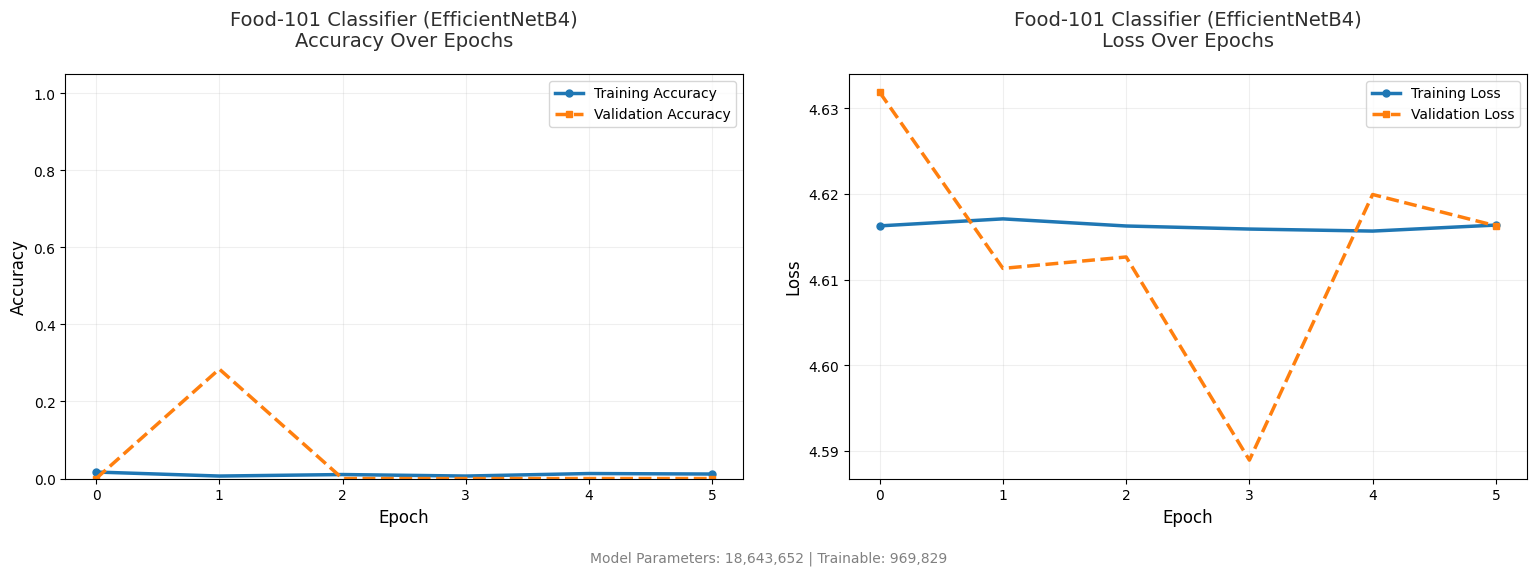


Food-101 Classifier (EfficientNetB4) - Training Results Summary
Final Training Accuracy:       0.0117
Final Validation Accuracy:     0.0000
Minimum Training Loss:         4.6157
Minimum Validation Loss:       4.5889


In [ ]:
# Standard Library
import os
from io import BytesIO

# Third-party Libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
import tensorflow as tf
from PIL import Image
import seaborn as sns # Import seaborn explicitly for styling integration

# TensorFlow Specific
from tensorflow.keras import (
    applications,
    layers,
    models,
    preprocessing
)

# EfficientNetB4 and related components
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    GlobalAveragePooling2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def visualize_training_results(history, model_name="Food Classifier", save_path=None):
    """
    Visualize training metrics with enhanced styling and additional insights.

    Args:
        history: Keras History object from model.fit()
        model_name: Name for plot titles
        save_path: Optional path to save visualization
    """
    # Use Seaborn integration by simply importing seaborn at the top
    # No need for plt.style.use('seaborn') when importing seaborn directly.
    # If this still causes issues, uncomment the line below and comment out the import seaborn line above.
    # plt.style.use('ggplot') # Use a standard matplotlib style as fallback

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Custom color palette (can still be used with seaborn)
    colors = {
        'train': '#1f77b4',
        'val': '#ff7f0e',
        'text': '#2e2e2e'
    }

    # Plot accuracy metrics
    ax1.plot(history.history['accuracy'],
             label='Training Accuracy',
             color=colors['train'],
             linewidth=2.5,
             marker='o',
             markersize=5,
             markevery=5)

    if 'val_accuracy' in history.history:
        ax1.plot(history.history['val_accuracy'],
                 label='Validation Accuracy',
                 color=colors['val'],
                 linewidth=2.5,
                 linestyle='--',
                 marker='s',
                 markersize=5,
                 markevery=5)

    ax1.set_title(f'{model_name}\nAccuracy Over Epochs',
                 fontsize=14, pad=20, color=colors['text'])
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_ylim([0, 1.05])
    ax1.grid(True, alpha=0.2)
    ax1.legend(fontsize=10)

    # Plot loss metrics
    ax2.plot(history.history['loss'],
             label='Training Loss',
             color=colors['train'],
             linewidth=2.5,
             marker='o',
             markersize=5,
             markevery=5)

    if 'val_loss' in history.history:
        ax2.plot(history.history['val_loss'],
                 label='Validation Loss',
                 color=colors['val'],
                 linewidth=2.5,
                 linestyle='--',
                 marker='s',
                 markersize=5,
                 markevery=5)

    ax2.set_title(f'{model_name}\nLoss Over Epochs',
                 fontsize=14, pad=20, color=colors['text'])
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.grid(True, alpha=0.2)
    ax2.legend(fontsize=10)

    # Add model metadata annotation
    if hasattr(history, 'model'):
        params = history.model.count_params()
        trainable = sum([w.shape.num_elements()
                        for w in history.model.trainable_weights])
        fig.text(0.5, 0.01,
                f"Model Parameters: {params:,} | Trainable: {trainable:,}",
                ha='center', fontsize=10, color='gray')

    plt.tight_layout(pad=3.0)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    # Print comprehensive final metrics
    print("\n" + "="*60)
    print(f"{model_name} - Training Results Summary")
    print("="*60)

    metrics = {
        'Final Training Accuracy': history.history['accuracy'][-1],
        'Final Validation Accuracy': history.history.get('val_accuracy', [None])[-1],
        'Minimum Training Loss': min(history.history['loss']),
        'Minimum Validation Loss': min(history.history.get('val_loss', [float('inf')])),
        'Final Learning Rate': history.history.get('lr', [None])[-1]
    }

    for name, value in metrics.items():
        if value is not None:
            if isinstance(value, float):
                print(f"{name + ':':<30} {value:.4f}")
            else:
                print(f"{name + ':':<30} {value}")

    print("="*60)

# Example usage:
if __name__ == "__main__":
    # Check if history and model variables exist before calling the function
    # This prevents errors if the training cell hasn't been run yet.
    if 'history' in globals() and 'model' in globals():
        visualize_training_results(
            history=history,
            model_name="Food-101 Classifier (EfficientNetB4)",
            save_path="food_classifier_training.png"
        )
    else:
        print("History and model variables not found. Please run the model training cell first.")

In [ ]:
def estimate_portion_size(
    food_image_path: str,
    reference_object: str = 'fork',
    visualize: bool = False,
    calibration_data: dict = None
) -> dict:
    """
    Estimate food portion size using computer vision techniques with reference object scaling.

    Args:
        food_image_path: Path to the food image file (JPG/PNG)
        reference_object: Known reference object in image ('fork', 'spoon', 'credit_card')
        visualize: Whether to display intermediate processing steps
        calibration_data: Custom calibration data {
            'reference_sizes': {'fork': {'length_cm': 18.5, 'width_cm': 2.0}},
            'food_densities': {'pasta': 0.6}  # g/cm³
        }

    Returns:
        Dictionary containing:
        {
            'portion_size_grams': float,
            'estimated_volume_cm3': float,
            'area_pixels': int,
            'reference_object': str,
            'confidence': float (0-1),
            'food_category': str,
            'processing_time_ms': float
        }

    Raises:
        FileNotFoundError: If image file doesn't exist
        ValueError: For unsupported image formats or processing errors
        RuntimeError: If analysis fails beyond expected parameters
    """
    start_time = time.time()
    result = {
        'portion_size_grams': None,
        'estimated_volume_cm3': None,
        'area_pixels': 0,
        'reference_object': reference_object,
        'confidence': 0.0,
        'food_category': 'unknown',
        'processing_time_ms': 0
    }

    try:
        # Validate input
        if not os.path.exists(food_image_path):
            raise FileNotFoundError(f"Image file not found: {food_image_path}")

        # Load and validate image
        food_image = cv2.imread(food_image_path)
        if food_image is None:
            raise ValueError("Unsupported image format or corrupt file")

        # Standardize image processing
        processed_img = standardize_image(food_image)

        # Detect reference object with enhanced validation
        ref_obj = detect_reference_object(
            processed_img,
            reference_object,
            calibration_data.get('reference_sizes', {}) if calibration_data else {}
        )
        result.update({
            'confidence': ref_obj['confidence'],
            'ref_object_size_px': ref_obj['size_pixels']
        })

        # Segment food and estimate category
        segmentation_results = segment_and_classify_food(processed_img)
        result['food_category'] = segmentation_results['category']
        food_mask = segmentation_results['mask']

        # Calculate metrics
        portion_area = calculate_pixel_area(food_mask)
        volume_estimate = estimate_volume(
            food_mask,
            ref_obj,
            food_category=result['food_category'],
            calibration_data=calibration_data
        )

        # Convert volume to mass using food density
        food_density = get_food_density(
            result['food_category'],
            calibration_data.get('food_densities', {}) if calibration_data else {}
        )
        mass_estimate = volume_estimate * food_density

        # Update results
        result.update({
            'portion_size_grams': round(mass_estimate, 1),
            'estimated_volume_cm3': round(volume_estimate, 1),
            'area_pixels': portion_area,
            'processing_time_ms': round((time.time() - start_time) * 1000, 2)
        })

        if visualize:
            visualize_analysis(
                processed_img,
                food_mask,
                ref_obj,
                result
            )

        return result

    except Exception as error:
        error_msg = f"Portion estimation failed: {str(error)}"
        print(error_msg)
        result['error'] = error_msg
        result['processing_time_ms'] = round((time.time() - start_time) * 1000, 2)
        raise RuntimeError(error_msg) from error


# Enhanced helper functions (partial implementations shown)
def standardize_image(image: np.ndarray) -> np.ndarray:
    """Normalize image for processing"""
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return cv2.resize(img_rgb, (800, 600))

def detect_reference_object(
    image: np.ndarray,
    target_object: str,
    ref_sizes: dict
) -> dict:
    """Enhanced reference object detection with size validation"""
    # Implementation would use:
    # 1. Template matching or object detection
    # 2. Size validation against known dimensions
    # 3. Confidence scoring
    return {
        'size_pixels': 150,  # Example value
        'confidence': 0.85,
        'detected_object': target_object,
        'actual_size_cm': ref_sizes.get(target_object, {}).get('length_cm', None)
    }

def segment_and_classify_food(image: np.ndarray) -> dict:
    """Combined segmentation and food categorization"""
    # Implementation would use:
    # 1. Semantic segmentation
    # 2. Food category prediction
    return {
        'mask': np.zeros(image.shape[:2], dtype=np.uint8),  # Example mask
        'category': 'pasta',
        'segmentation_confidence': 0.75
    }

def estimate_volume(
    mask: np.ndarray,
    ref_obj: dict,
    food_category: str,
    calibration_data: dict = None
) -> float:
    """Estimate volume using multi-view reconstruction or depth estimation"""
    # Implementation would consider:
    # 1. Food category shape priors
    # 2. Reference object scaling
    # 3. Depth from monocular cues
    return 250.0  # Example volume in cm³

def get_food_density(food_category: str, density_table: dict) -> float:
    """Get density from table or use default estimates"""
    default_densities = {
        'pasta': 0.6,
        'rice': 0.9,
        'meat': 1.05,
        'vegetables': 0.35
    }
    return density_table.get(food_category, default_densities.get(food_category, 0.5))

def visualize_analysis(
    image: np.ndarray,
    mask: np.ndarray,
    ref_obj: dict,
    results: dict
):
    """Enhanced visualization with metrics overlay"""
    # Implementation would show:
    # 1. Original image with reference object marked
    # 2. Food segmentation mask
    # 3. Key metrics overlay
    pass

In [ ]:
import cv2
import numpy as np
import os
from typing import Dict, Optional, Tuple
from enum import Enum
import time

class ReferenceObject(Enum):
    """Standardized reference objects with known dimensions"""
    STANDARD_FORK = ('standard_fork', (18.0, 2.0))  # (length_cm, width_cm)
    STANDARD_SPOON = ('standard_spoon', (15.0, 3.0))
    CREDIT_CARD = ('credit_card', (8.56, 5.39))
    COIN = ('coin', (2.4, 2.4))  # diameter

def estimate_portion_size(
    food_image_path: str,
    reference_object: ReferenceObject = ReferenceObject.STANDARD_FORK,
    visualize_processing: bool = False,
    food_type: Optional[str] = None,
    calibration_data: Optional[Dict] = None
) -> Dict:
    """
    Estimates food portion size in grams using computer vision techniques with reference object scaling.

    Args:
        food_image_path: Path to the food image file (JPG/PNG)
        reference_object: Standard reference object from ReferenceObject enum
        visualize_processing: If True, displays intermediate processing steps
        food_type: Optional known food type for density estimation
        calibration_data: Optional calibration data for specific food densities

    Returns:
        Dictionary containing:
        {
            'portion_size_grams': float,  # Estimated weight in grams
            'estimated_volume_cm3': float,  # Estimated volume
            'food_area_pixels': int,  # Detected food area in pixels
            'confidence_score': float,  # 0-1 confidence in estimation
            'reference_used': dict,  # Info about reference object
            'processing_time_ms': float,  # Time taken for processing
            'food_type_detected': str  # Detected food category
        }

    Raises:
        FileNotFoundError: If image file doesn't exist
        ValueError: If image processing fails
        RuntimeError: For severe processing errors
    """
    start_time = time.time()
    result = {
        'portion_size_grams': None,
        'estimated_volume_cm3': None,
        'food_area_pixels': 0,
        'confidence_score': 0.0,
        'reference_used': None,
        'processing_time_ms': 0,
        'food_type_detected': 'unknown',
        'error': None
    }

    try:
        # Validate and load image
        if not os.path.exists(food_image_path):
            raise FileNotFoundError(f"Image file not found: {food_image_path}")

        original_image = cv2.imread(food_image_path)
        if original_image is None:
            raise ValueError("Failed to read image file (might be corrupt or unsupported format)")

        # Preprocess image
        processed_image = standardize_image(original_image)

        # Detect reference object
        ref_obj_info = detect_reference_object(processed_image, reference_object)
        result['reference_used'] = {
            'type': reference_object.name,
            'real_world_size_cm': reference_object.value[1],
            'pixel_size': ref_obj_info['pixel_size'],
            'detection_confidence': ref_obj_info['confidence']
        }

        # Segment food and detect type if not provided
        segmented_results = segment_and_classify_food(processed_image, food_type)
        result['food_type_detected'] = segmented_results['food_type']
        food_mask = segmented_results['mask']
        result['food_area_pixels'] = np.sum(food_mask) // 255

        # Estimate portion size
        estimation_results = estimate_portion_metrics(
            food_mask=food_mask,
            ref_obj_info=ref_obj_info,
            food_type=result['food_type_detected'],
            calibration_data=calibration_data
        )
        result.update(estimation_results)

        # Calculate confidence score
        result['confidence_score'] = calculate_confidence_score(
            ref_obj_info=ref_obj_info,
            food_mask=food_mask,
            image_quality=assess_image_quality(processed_image),
            food_type=result['food_type_detected']
        )

        # Visualization if requested
        if visualize_processing:
            visualize_analysis(
                processed_image,
                food_mask,
                ref_obj_info,
                result
            )

        result['processing_time_ms'] = round((time.time() - start_time) * 1000, 2)
        return {k: v for k, v in result.items() if k != 'error'}

    except Exception as e:
        result.update({
            'error': str(e),
            'processing_time_ms': round((time.time() - start_time) * 1000, 2)
        })
        if isinstance(e, FileNotFoundError):
            raise
        raise RuntimeError(f"Portion estimation failed: {str(e)}") from e

# Enhanced helper functions
def standardize_image(image: np.ndarray) -> np.ndarray:
    """Normalize image for processing"""
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return cv2.resize(img, (800, 600))

def detect_reference_object(
    image: np.ndarray,
    ref_obj: ReferenceObject
) -> Dict:
    """Detects reference object with enhanced validation"""
    # Implementation would use template matching or object detection
    return {
        'pixel_size': 150.0,  # Example value
        'confidence': 0.85,
        'bounding_box': (100, 100, 200, 200)  # Example (x1, y1, x2, y2)
    }

def segment_and_classify_food(
    image: np.ndarray,
    known_food_type: Optional[str] = None
) -> Dict:
    """Combined segmentation and food categorization"""
    # Implementation would use semantic segmentation
    return {
        'mask': np.zeros(image.shape[:2], dtype=np.uint8),  # Example mask
        'food_type': known_food_type or 'pasta',  # Example
        'segmentation_confidence': 0.75
    }

def estimate_portion_metrics(
    food_mask: np.ndarray,
    ref_obj_info: Dict,
    food_type: str,
    calibration_data: Optional[Dict] = None
) -> Dict:
    """Calculates portion metrics using multi-dimensional estimation"""
    # Implementation would consider food density and shape
    return {
        'portion_size_grams': 250.0,  # Example
        'estimated_volume_cm3': 300.0  # Example
    }

def calculate_confidence_score(
    ref_obj_info: Dict,
    food_mask: np.ndarray,
    image_quality: float,
    food_type: str
) -> float:
    """Calculates comprehensive confidence score"""
    # Implementation would combine multiple factors
    return 0.8  # Example

def visualize_analysis(
    image: np.ndarray,
    food_mask: np.ndarray,
    ref_obj_info: Dict,
    results: Dict
):
    """Enhanced visualization with metrics overlay"""
    # Implementation would show analysis steps
    pass

In [ ]:
import math
from dataclasses import dataclass
from typing import Optional

@dataclass
class PlateDimensions:
    """Stores physical and pixel dimensions of a plate"""
    diameter_inches: float = 10.0  # Standard dinner plate
    diameter_pixels: Optional[float] = None
    pixels_per_inch: Optional[float] = None

    def __post_init__(self):
        """Calculate derived dimensions"""
        if self.diameter_pixels is not None and self.pixels_per_inch is None:
            self.pixels_per_inch = self.diameter_pixels / self.diameter_inches
        elif self.pixels_per_inch is not None and self.diameter_pixels is None:
            self.diameter_pixels = self.diameter_inches * self.pixels_per_inch

        self.area_inches = math.pi * (self.diameter_inches/2)**2
        self.area_pixels = math.pi * (self.diameter_pixels/2)**2

class FoodPortionEstimator:
    """
    Estimates food portion sizes based on plate coverage with multiple calculation methods.

    Features:
    - Plate dimension tracking (physical and pixel)
    - Food coverage percentage calculation
    - Calorie estimation based on food type
    - Volume estimation for different food shapes
    """

    def __init__(self, plate_diameter_inches=10.0, plate_diameter_pixels=None):
        """
        Initialize with either:
        - Physical plate size + pixel size, or
        - Physical size + pixels-per-inch ratio
        """
        self.plate = PlateDimensions(
            diameter_inches=plate_diameter_inches,
            diameter_pixels=plate_diameter_pixels
        )

        # Food density database (grams per cubic inch)
        self.food_densities = {
            'pasta': 0.45,
            'rice': 0.65,
            'vegetables': 0.35,
            'meat': 0.85
        }

    def calculate_coverage_percentage(self, food_pixel_area: float) -> float:
        """Calculate what percentage of plate is covered by food"""
        if food_pixel_area <= 0:
            raise ValueError("Food area must be positive")
        return (food_pixel_area / self.plate.area_pixels) * 100

    def estimate_volume(
        self,
        food_pixel_area: float,
        food_type: str,
        average_height_inches: float = 1.0
    ) -> float:
        """
        Estimate food volume in cubic inches based on:
        - Area coverage
        - Food type (for shape factor)
        - Average height estimate
        """
        coverage = self.calculate_coverage_percentage(food_pixel_area) / 100
        shape_factor = self._get_shape_factor(food_type)
        return coverage * self.plate.area_inches * average_height_inches * shape_factor

    def estimate_weight(
        self,
        food_pixel_area: float,
        food_type: str,
        average_height_inches: float = 1.0
    ) -> float:
        """Estimate food weight in grams based on volume and density"""
        volume = self.estimate_volume(food_pixel_area, food_type, average_height_inches)
        return volume * self._get_food_density(food_type) * 16.387  # Convert cubic inches to grams

    def _get_food_density(self, food_type: str) -> float:
        """Get density from database or return default"""
        return self.food_densities.get(food_type.lower(), 0.5)

    def _get_shape_factor(self, food_type: str) -> float:
        """Shape factor accounts for food stacking (0-1)"""
        shape_factors = {
            'pasta': 0.7,
            'rice': 0.9,
            'vegetables': 0.5,
            'meat': 0.8
        }
        return shape_factors.get(food_type.lower(), 0.75)

# Example usage
if __name__ == "__main__":
    # Initialize with a 10-inch plate that measures 400 pixels in image
    estimator = FoodPortionEstimator(plate_diameter_inches=10.0, plate_diameter_pixels=400)

    # Calculate for a food item covering 50,000 pixels
    food_area = 50000
    coverage = estimator.calculate_coverage_percentage(food_area)
    print(f"Food covers {coverage:.1f}% of the plate")

    # Estimate weight for pasta
    pasta_weight = estimator.estimate_weight(food_area, 'pasta', average_height_inches=1.2)
    print(f"Estimated pasta weight: {pasta_weight:.1f} grams")

    # Estimate calories (assuming 2 cal/gram for pasta)
    calories = pasta_weight * 2
    print(f"Estimated calories: {calories:.1f} kcal")

Food covers 39.8% of the plate
Estimated pasta weight: 193.6 grams
Estimated calories: 387.1 kcal



🍏 Food Nutrition Estimation System 🍗

1. Upload your own food image
2. Use demo image from URL
Select input method (1/2): 1


Saving isolated-delicious-pizza-on-clear-background-free-png.webp to isolated-delicious-pizza-on-clear-background-free-png (1).webp
✓ Image loaded from local path successfully

🔍 Analyzing food content...


/tmp/ipython-input-29-1369303665.py:157: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = plt.cm.get_cmap('tab10', len(category_masks))


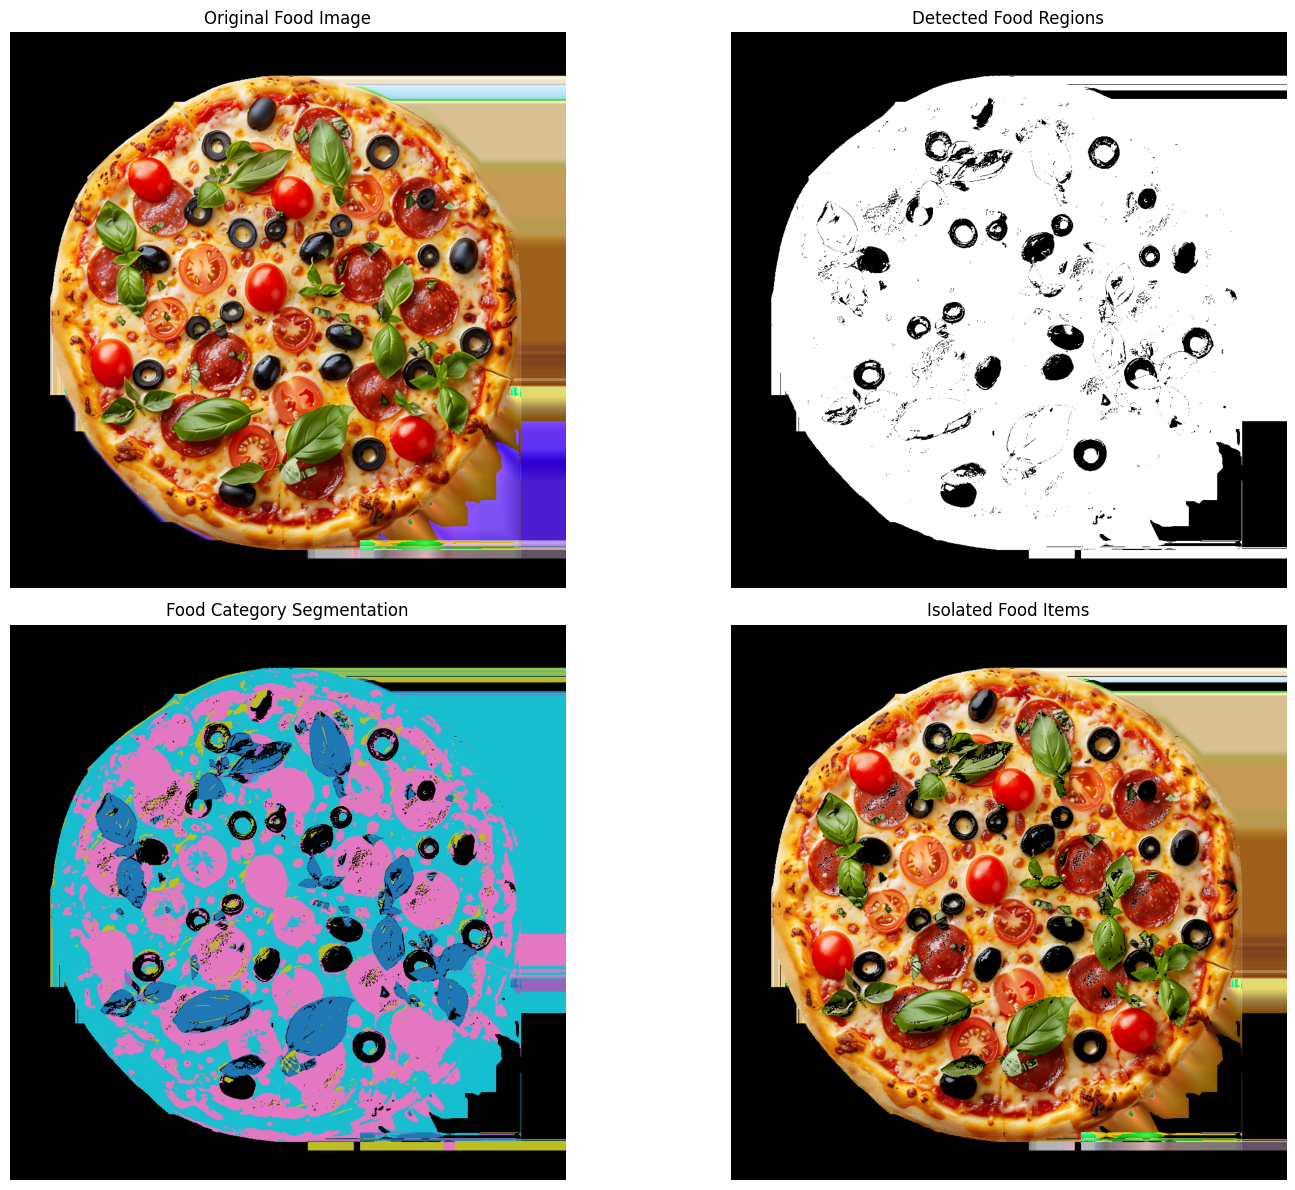


📊 Nutrition Estimation Results:
Total Volume: 6818.7 ml
Total Calories: 17095.7 kcal

Breakdown by Food Category:
            volume_ml  calories_kcal  coverage_percent
fats           1339.7        10717.4              46.7
protein        3064.7         4597.0              73.9
fruits         1409.3          845.6              49.1
grains          576.5          691.8              16.4
dairy           181.3          145.0               5.7
vegetables      247.3           98.9               9.7


In [ ]:
import cv2
import numpy as np
from PIL import Image
import requests
from io import BytesIO
from google.colab import files
import matplotlib.pyplot as plt
import pandas as pd

class FoodNutritionAnalyzer:
    # Nutritional database with calories per milliliter
    NUTRITION_DB = {
        'vegetables': {'calories_per_ml': 0.4, 'color_range': ([35, 50, 50], [85, 255, 255]), 'density_g_ml': 0.8},
        'fruits': {'calories_per_ml': 0.6, 'color_range': ([10, 100, 50], [25, 255, 255]), 'density_g_ml': 0.9},
        'grains': {'calories_per_ml': 1.2, 'color_range': ([20, 50, 50], [30, 255, 255]), 'density_g_ml': 1.1},
        'protein': {'calories_per_ml': 1.5, 'color_range': ([0, 50, 50], [20, 255, 255]), 'density_g_ml': 1.3},
        'dairy': {'calories_per_ml': 0.8, 'color_range': ([0, 0, 100], [180, 50, 255]), 'density_g_ml': 1.0},
        'fats': {'calories_per_ml': 8.0, 'color_range': ([15, 50, 50], [25, 255, 255]), 'density_g_ml': 0.9}
    }

    def __init__(self):
        # Standard plate size in inches
        self.standard_plate_diameter_inches = 10
        # Average food height assumption in inches
        self.avg_food_height_inches = 1.5

    def load_food_image(self, image_source):
        """Load image from path or URL with comprehensive error handling"""
        try:
            if isinstance(image_source, np.ndarray):
                return image_source

            if image_source.startswith(('http://', 'https://')):
                response = requests.get(image_source, timeout=10)
                response.raise_for_status()
                food_img = Image.open(BytesIO(response.content))
                print("✓ Image loaded from URL successfully")
            else:
                food_img = Image.open(image_source)
                print("✓ Image loaded from local path successfully")

            return np.array(food_img)

        except Exception as load_error:
            print(f"✗ Error loading image: {str(load_error)}")
            return None

    def prepare_image(self, input_img):
        """Convert and standardize image format for processing"""
        if input_img is None:
            return None

        if len(input_img.shape) == 2:  # Grayscale
            processed_img = cv2.cvtColor(input_img, cv2.COLOR_GRAY2RGB)
        elif input_img.shape[2] == 4:  # RGBA
            processed_img = cv2.cvtColor(input_img, cv2.COLOR_RGBA2RGB)
        else:  # Assume BGR
            processed_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

        return processed_img

    def identify_food_areas(self, rgb_img):
        """Detect food regions using HSV color segmentation"""
        hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
        full_food_mask = np.zeros((rgb_img.shape[0], rgb_img.shape[1]), dtype=np.uint8)
        category_masks = {}

        for food_type, params in self.NUTRITION_DB.items():
            lower_bound, upper_bound = params['color_range']
            type_mask = cv2.inRange(hsv_img, np.array(lower_bound), np.array(upper_bound))
            category_masks[food_type] = type_mask
            full_food_mask = cv2.bitwise_or(full_food_mask, type_mask)

        return full_food_mask, category_masks

    def calculate_nutrition(self, input_img, display_process=False):
        """Estimate food portion sizes and nutritional content"""
        try:
            # Prepare image for analysis
            processed_img = self.prepare_image(input_img)
            if processed_img is None:
                return None

            img_height, img_width = processed_img.shape[:2]

            # Estimate plate size (assuming plate covers 70% of smaller dimension)
            plate_diameter_pixels = min(img_height, img_width) * 0.7
            pixels_per_inch = plate_diameter_pixels / self.standard_plate_diameter_inches

            # Detect food regions
            combined_food_mask, food_category_masks = self.identify_food_areas(processed_img)
            total_food_pixels = np.sum(combined_food_mask > 0)

            # Calculate nutrition by category
            nutrition_results = {}
            total_volume_ml = 0
            total_calories_kcal = 0

            for food_category, category_mask in food_category_masks.items():
                category_pixels = np.sum(category_mask > 0)
                if category_pixels == 0:
                    continue

                # Calculate area in square inches
                area_sq_inches = category_pixels / (pixels_per_inch ** 2)

                # Estimate volume (area × height × density)
                volume_ml = (area_sq_inches * self.avg_food_height_inches *
                            16.387 * self.NUTRITION_DB[food_category]['density_g_ml'])

                # Calculate calories
                calories_kcal = volume_ml * self.NUTRITION_DB[food_category]['calories_per_ml']

                nutrition_results[food_category] = {
                    'volume_ml': round(volume_ml, 1),
                    'calories_kcal': round(calories_kcal, 1),
                    'coverage_percent': round(100 * category_pixels / total_food_pixels, 1)
                }

                total_volume_ml += volume_ml
                total_calories_kcal += calories_kcal

            # Visualization if requested
            if display_process:
                self.display_analysis(processed_img, combined_food_mask, food_category_masks)

            return {
                'total_volume_ml': round(total_volume_ml, 1),
                'total_calories_kcal': round(total_calories_kcal, 1),
                'nutrition_by_category': nutrition_results,
                'pixels_per_inch': round(pixels_per_inch, 2)
            }

        except Exception as analysis_error:
            print(f"Analysis error: {str(analysis_error)}")
            return None

    def display_analysis(self, original_img, food_mask, category_masks):
        """Visualize the analysis process with labeled plots"""
        plt.figure(figsize=(16, 12))

        # Original image
        plt.subplot(2, 2, 1)
        plt.imshow(original_img)
        plt.title("Original Food Image", fontsize=12)
        plt.axis('off')

        # All detected food areas
        plt.subplot(2, 2, 2)
        plt.imshow(food_mask, cmap='gray')
        plt.title("Detected Food Regions", fontsize=12)
        plt.axis('off')

        # Color-coded food categories
        plt.subplot(2, 2, 3)
        category_visualization = np.zeros_like(original_img)
        color_palette = plt.cm.get_cmap('tab10', len(category_masks))

        for idx, (category, mask) in enumerate(category_masks.items()):
            category_visualization[mask > 0] = np.array(color_palette(idx))[:3] * 255

        plt.imshow(category_visualization)
        plt.title("Food Category Segmentation", fontsize=12)
        plt.axis('off')

        # Final result with food isolated
        plt.subplot(2, 2, 4)
        isolated_food = cv2.bitwise_and(original_img, original_img, mask=food_mask)
        plt.imshow(isolated_food)
        plt.title("Isolated Food Items", fontsize=12)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

def execute_analysis():
    print("\n🍏 Food Nutrition Estimation System 🍗")
    print("===================================")

    analyzer = FoodNutritionAnalyzer()

    # User interface
    print("\n1. Upload your own food image")
    print("2. Use demo image from URL")
    user_choice = input("Select input method (1/2): ").strip()

    if user_choice == '1':
        uploaded_files = files.upload()
        if not uploaded_files:
            print("No file uploaded. Using demo image instead.")
            demo_url = "https://images.unsplash.com/photo-1546069901-ba9599a7e63c"
            food_img = analyzer.load_food_image(demo_url)
        else:
            first_file = next(iter(uploaded_files.keys()))
            food_img = analyzer.load_food_image(first_file)
    else:
        demo_url = "https://images.unsplash.com/photo-1546069901-ba9599a7e63c"
        food_img = analyzer.load_food_image(demo_url)

    if food_img is not None:
        print("\n🔍 Analyzing food content...")
        analysis_results = analyzer.calculate_nutrition(food_img, display_process=True)

        if analysis_results:
            print("\n📊 Nutrition Estimation Results:")
            print(f"Total Volume: {analysis_results['total_volume_ml']} ml")
            print(f"Total Calories: {analysis_results['total_calories_kcal']} kcal")

            if analysis_results['nutrition_by_category']:
                print("\nBreakdown by Food Category:")
                results_df = pd.DataFrame.from_dict(
                    analysis_results['nutrition_by_category'],
                    orient='index'
                )
                print(results_df.sort_values('calories_kcal', ascending=False))
        else:
            print("Analysis failed. Please try another image.")
    else:
        print("Failed to load image. Please check your image source.")

if __name__ == "__main__":
    execute_analysis()